## DBSCAN+KNN WAVEFORM CLEANER 
This code was developed by Izabela Lima Paiva, for use with spikesorted data, or waveforms in general with the aim of noise isolation. 
Last update: 26.10.2025 - Using VisualStudio Code 

The output of this will be an .npz file with the clean waveforms; timestemps of the clean cluester and the noise cluster as well. 
Also it will be printed a figure with the waveforms within the noise cluster and the real spikes cluster, see on the Github page some examples of it. 

### Libraries Import 
In this session we will load all the necessary libraries for the proper use of the code. 
Mase sure you enviriment have all the features described in the neuro_dance.yml 

In [7]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.covariance import EmpiricalCovariance

### Definition of the functions to : Load the data, extract feature, and proceed with noise isolation by implementing DBSCAN labeling and KNN labeling

In [9]:
# ─── Load of the Kilosort output after global manual curation ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
def load_ks_data(data_folder):
    return {
        'spike_times': np.load(os.path.join(data_folder, 'spike_times.npy')).flatten(),  # 1D
        'spike_clusters': np.load(os.path.join(data_folder, 'spike_clusters.npy')).flatten(),
        'spike_templates': np.load(os.path.join(data_folder, 'spike_templates.npy')).flatten(),
        'templates': np.load(os.path.join(data_folder, 'templates.npy')),
        'channel_map': np.load(os.path.join(data_folder, 'channel_map.npy')).flatten(),
        'good_clusters': pd.read_csv(os.path.join(data_folder, 'cluster_group.tsv'), sep='\t')
                           .query("group == 'good'")['cluster_id'].values
    }

def load_dat_channel(raw_path, chan, n_chan, dtype=np.int16):
    n_samples = os.path.getsize(raw_path) // (np.dtype(dtype).itemsize * n_chan)
    raw = np.memmap(raw_path, dtype=dtype, mode='r').reshape(n_samples, n_chan)
    return raw[:, chan]

# ─── Channel maping trhough CSV ( For this remember to provide the .csv file with the cluster number in the first column and the peak channel on the second, you can download .csv if you like ;D) ───────────────────
def load_cluster_channel_mapping_from_csv(csv_path):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Mapping CSV not found: {csv_path}")

    try:
        df = pd.read_csv(csv_path, engine='python')
        if df.shape[1] < 2:
            raise ValueError("CSV has fewer than 2 columns.")
        possible_cluster_cols = [c for c in df.columns if str(c).strip().lower() in ('cluster', 'cluster_id', 'clusterid')]
        possible_channel_cols = [c for c in df.columns if str(c).strip().lower() in ('channel', 'peak_channel', 'channel_id', 'peakchannel')]
        if possible_cluster_cols and possible_channel_cols:
            ccol = possible_cluster_cols[0]
            chcol = possible_channel_cols[0]
            df = df[[ccol, chcol]].copy()
            df.columns = ['cluster_id', 'channel']
        else:
            df = df.iloc[:, :2].copy()
            df.columns = ['cluster_id', 'channel']
    except Exception:
        df = pd.read_csv(csv_path, engine='python', header=None)
        if df.shape[1] < 2:
            raise ValueError("CSV has fewer than 2 columns.")
        df = df.iloc[:, :2].copy()
        df.columns = ['cluster_id', 'channel']

    df = df.dropna(subset=['cluster_id', 'channel']).copy()

    def _to_int_series(s, name):
        out = pd.to_numeric(s, errors='coerce')
        bad = out.isna().sum()
        if bad > 0:
            print(f"[WARN] Dropping {bad} rows with non-integer {name}.")
        return out.dropna().astype(int)

    df['cluster_id'] = _to_int_series(df['cluster_id'], 'cluster_id')
    df['channel'] = _to_int_series(df['channel'], 'channel')
    df = df.drop_duplicates(subset=['cluster_id'])

    mapping = dict(zip(df['cluster_id'].values, df['channel'].values))
    print(f"[INFO] Loaded {len(mapping)} cluster→channel pairs from CSV.")
    return mapping

# ─── Waveforms features extraction ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
def align_and_baseline(waveforms, fs, pre_frac=0.4, align_window_frac=0.4):
    W = np.asarray(waveforms, dtype=float)
    n_spk, n = W.shape
    center = n // 2
    pre_len = max(5, int(pre_frac * center))
    W = W - np.mean(W[:, :pre_len], axis=1, keepdims=True)

    half = int(align_window_frac * center)
    l = max(0, center - half)
    r = min(n, center + half)

    trough_idx = np.argmin(W[:, l:r], axis=1) + l
    shifts = center - trough_idx

    aligned = np.empty_like(W)
    for i, sh in enumerate(shifts):
        if sh == 0:
            aligned[i] = W[i]
        elif sh > 0:
            aligned[i, sh:] = W[i, :n - sh]
            aligned[i, :sh] = 0.0
        else:
            sh = -sh
            aligned[i, :n - sh] = W[i, sh:]
            aligned[i, n - sh:] = 0.0
    return aligned, np.full(n_spk, center, dtype=int)

def spike_features_one(w, fs):
    n = len(w)
    center = n // 2

    trough_idx = int(np.argmin(w))
    trough_val = float(w[trough_idx])

    post_start = min(trough_idx + 1, n - 1)
    post_end = n
    if post_end - post_start < 2:
        return None
    peak_rel = int(np.argmax(w[post_start:post_end]))
    peak_idx = post_start + peak_rel
    peak_val = float(w[peak_idx])

    ptp = peak_val - trough_val
    tp_time = (peak_idx - trough_idx) / fs

    dw = np.gradient(w) * fs
    d2w = np.gradient(dw) * fs

    repol_slope = float(np.max(dw[trough_idx:peak_idx])) if peak_idx - trough_idx > 2 else np.nan

    rec_stop = min(n, peak_idx + int(0.0008 * fs))
    recovery_slope = float(np.median(dw[peak_idx:rec_stop])) if rec_stop - peak_idx > 2 else np.nan

    thr = trough_val * 0.5
    li = trough_idx
    while li > 0 and w[li] < thr:
        li -= 1
    ri = trough_idx
    while ri < n - 1 and w[ri] < thr:
        ri += 1
    half_width = (ri - li) / fs if ri > li else np.nan

    asymmetry = peak_val / abs(trough_val) if abs(trough_val) > 1e-12 else np.nan
    energy = float(np.sum(w ** 2))
    area_abs = float(np.sum(np.abs(w)))

    curv_trough = float(d2w[trough_idx])
    curv_peak = float(d2w[peak_idx])

    pre_end = max(5, int(0.2 * center))
    noise_std = float(np.std(w[:pre_end])) if pre_end > 5 else float(np.std(w[:max(5, trough_idx)]))
    snr = ptp / (noise_std + 1e-12)

    return [
        trough_val, peak_val, ptp, tp_time, half_width,
        repol_slope, recovery_slope, asymmetry,
        energy, area_abs, curv_trough, curv_peak, snr
    ]

def extract_features_scaled(waveforms, n_pcs=4, sample_rate = 20000.0):
    fs = float(sample_rate)
    aligned, _ = align_and_baseline(waveforms, fs)

    feats = []
    for w in aligned:
        f = spike_features_one(w, fs)
        if f is None:
            f = [np.nan] * 13
        feats.append(f)
    feats = np.asarray(feats, dtype=float)

    col_med = np.nanmedian(feats, axis=0)
    inds = np.where(np.isnan(feats))
    feats[inds] = np.take(col_med, inds[1])
    feats = np.nan_to_num(feats, nan=0.0, posinf=0.0, neginf=0.0)

    ptp_vec = feats[:, 2].copy()
    snr_vec = feats[:, -1].copy()

    pca = None
    if n_pcs and n_pcs > 0:
        pca = PCA(n_components=min(n_pcs, aligned.shape[1]))
        pcs = pca.fit_transform(aligned)
        features = np.hstack([feats, pcs])
    else:
        features = feats

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled, pca, ptp_vec, snr_vec

# ─── DBSCAN with downsampling (plus only allows two groups -1 noise, and zero real spikes) ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
def cluster_waveforms_dbscan_with_knn(
    features_scaled,
    max_samples=5000,
    eps=2.8,
    min_samples=5,
    enforce_one_real=True,
    rescue=True,
    rescue_ptp=None,      # absolute PTP cutoff in SD units (on engineered features space), or None
    rescue_ptp_q=0.60,    # or promote if ptp above this quantile among all spikes
    rescue_snr_q=0.60,    # and snr above this quantile
    rescue_mahal=1.5      # and Mahalanobis distance < this threshold to real cluster
):
    """
    Run DBSCAN on subset of waveforms from each cluster, and will apply it to all the waveforms via KNN (for a better management of large size units).
    If enforce_one_real=True, collapse all non-noise clusters to the single largest real cluster (label 0).
    Everything else becomes noise (-1). Optionally rescue high-quality spikes from noise.
    """
    n_samples = len(features_scaled)
    if n_samples > max_samples:
        idx = np.random.choice(n_samples, max_samples, replace=False)
        sample_features = features_scaled[idx]
    else:
        idx = np.arange(n_samples)
        sample_features = features_scaled

    db = DBSCAN(eps=eps, min_samples=min_samples)
    sample_labels = db.fit_predict(sample_features)

    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(sample_features, sample_labels)
    all_labels = clf.predict(features_scaled)

    if enforce_one_real:
        non_noise = [lab for lab in np.unique(all_labels) if lab >= 0]
        if len(non_noise) == 0:
            # Low density (eg low number of such ype of wave forms): will be classified as noise
            final = np.full_like(all_labels, -1, dtype=int)
            return final
        # High density largest number of waveforms with the same shape will be classified as "real spikes "
        sizes = [(lab, int(np.sum(all_labels == lab))) for lab in non_noise]
        real_lab = max(sizes, key=lambda x: x[1])[0]
        final = np.full_like(all_labels, -1, dtype=int)
        real_mask = (all_labels == real_lab)
        final[real_mask] = 0  # only one real label: 0

        # Optional: rescue step (Transfer good spikes from noise to real) - A bit tricky because sometimes the real spikes passed as noise are not as dense
        if rescue:
            try:
               
                X = features_scaled
                X_real = X[real_mask]
                if X_real.shape[0] >= 10:
                    ecov = EmpiricalCovariance().fit(X_real)
                    center = X_real.mean(axis=0)
                    # distance of all noise points to real center
                    X_noise = X[final == -1]
                    if X_noise.shape[0] > 0:
                        d_mahal = ecov.mahalanobis(X_noise - center) ** 0.5
                        # convert to array aligned with full index
                        d_full = np.full(X.shape[0], np.inf)
                        d_full[final == -1] = d_mahal
                    else:
                        d_full = np.full(X.shape[0], np.inf)
                else:
                    d_full = np.full(features_scaled.shape[0], np.inf)

            except Exception as e:
                print(f"[WARN] Rescue distance calc failed: {e}")

        return final
    else:
        # fallback: compact {0,1,...} for non-noise
        kept = sorted([lab for lab in np.unique(all_labels) if lab >= 0])
        remap = {lab: i for i, lab in enumerate(kept)}
        out = np.array([(-1 if lab == -1 else remap[lab]) for lab in all_labels], dtype=int)
        return out

# ─── Plotting ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
def plot_pca_scatter(features_scaled, labels, cluster_id):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Color palette with waveform plot and PCAs 
    unique_labels = np.unique(labels)
    colors = sns.color_palette("husl", len(unique_labels))
    color_map = {lab: colors[i % len(colors)] for i, lab in enumerate(unique_labels)}
    color_map[-1] = (0.6, 0.2, 0.2) 

    # assign color per label
    point_colors = [color_map.get(lab, (0.5, 0.5, 0.5)) for lab in labels]

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(
        features_scaled[:, 0],
        features_scaled[:, 1],
        c=point_colors,
        alpha=0.5,
        s=15,
        edgecolors='none'
    )

    plt.xlabel("Waveforms features (Amplitude, PTP, Width)")
    plt.ylabel("Cluster variability")
    plt.title(f"Waveforms - Cluster {cluster_id}")

    # custom legend matching waveform colors
    handles = []
    for lab in unique_labels:
        handles.append(
            plt.Line2D(
                [0], [0],
                marker='o',
                color='w',
                markerfacecolor=color_map[lab],
                markersize=8,
                label=f"Real Spikes {lab}" if lab != -1 else "Noise (-1)"
            )
        )
    plt.legend(handles=handles, title="Clusters", loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

def _center_waveforms_y0(W):
    if W is None or W.size == 0:
        return W
    W = np.asarray(W, dtype=np.float32)
    return W - W.mean(axis=1, keepdims=True)

def plot_clustered_waveforms(
    waveforms, labels, cluster_id, peak_channel_id, max_waveforms_per_cluster=500, spike_times=None
):
    import seaborn as sns
    from matplotlib import gridspec
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import numpy as np
    import matplotlib.pyplot as plt

    waveforms = np.asarray(waveforms)
    unique_labels = np.unique(labels)

    def _peak_after_center(W):
        if W is None or W.size == 0:
            return 0.0
        Wc = _center_waveforms_y0(W)
        return float(np.max(Wc)) if Wc.size else 0.0

    # reference waveform for scaling
    if np.any(labels == 0):
        ref_W = waveforms[labels == 0]
    else:
        non_noise = unique_labels[unique_labels >= 0]
        if non_noise.size:
            counts = [(lab, np.sum(labels == lab)) for lab in non_noise]
            ref_label = max(counts, key=lambda x: x[1])[0]
            ref_W = waveforms[labels == ref_label]
        else:
            ref_W = waveforms[labels != -1] if np.any(labels != -1) else waveforms

    peak_ref = _peak_after_center(ref_W)
    y_lim = peak_ref + 100.0
    if not np.isfinite(y_lim) or y_lim <= 0:
        y_lim = 100.0

    # basic settings
    colors = sns.color_palette("husl", len(unique_labels))
    noise_mask = (labels == -1)
    clean_mask = (labels == 0)

    fs = float(globals().get('sample_rate', globals().get('FS', 20000.0)))
    WINDOW_MS_val = float(globals().get('WINDOW_MS', 50.0))
    BIN_MS_val    = float(globals().get('BIN_MS', 1.0))
    ACG_XLIM_MS_val = float(globals().get('ACG_XLIM_MS', 50.0))
    REFRACTORY_MS = 2.0  # refractory window for violations and vertical lines

    AMP_METHOD_val   = globals().get('AMP_METHOD', 'ptp')
    SCATTER_MARKER_SIZE_val = int(globals().get('SCATTER_MARKER_SIZE', 6))
    SCATTER_ALPHA_val = float(globals().get('SCATTER_ALPHA', 0.6))
    SUBSAMPLE_POINTS_val = globals().get('SUBSAMPLE_POINTS', None)

    # helper: waveform plot
    def _plot_waveforms(ax, W, title, color_non_noise=(0.2, 0.6, 0.6), is_noise=False):
        if W.shape[0] > max_waveforms_per_cluster:
            idx = np.random.choice(W.shape[0], max_waveforms_per_cluster, replace=False)
            W = W[idx]
        Wc = _center_waveforms_y0(W)
        col = (0.6, 0.2, 0.2) if is_noise else color_non_noise
        alpha = 0.05 if is_noise else 0.02
        if Wc.size:
            for wf in Wc:
                ax.plot(wf, color=col, alpha=alpha, linewidth=0.8)
            ax.plot(Wc.mean(axis=0), color='black', linewidth=2)
        ax.set_title(f"{title}\n{W.shape[0]} spikes")
        ax.set_xlabel("Samples")
        ax.set_ylabel("Amplitude (centered)")
        ax.set_ylim(-y_lim, y_lim)
        ax.axhline(0, color='gray', linewidth=1, linestyle='--', alpha=0.7)

    # helper: compute ACG and violations
    def _compute_acg_and_violations(ts_samples, window_ms, bin_ms, refractory_ms=2.0):
        if ts_samples is None or len(ts_samples) == 0:
            return None, None, None
        t_ms = (np.asarray(ts_samples, dtype=np.float64) / fs) * 1000.0
        t_ms.sort()

        lags = []
        half_window = window_ms
        n = t_ms.size
        j = 0
        for i in range(n):
            while j < n and t_ms[j] < t_ms[i] - half_window:
                j += 1
            k = i + 1
            while k < n and t_ms[k] <= t_ms[i] + half_window:
                dt = t_ms[k] - t_ms[i]
                if dt > 0:
                    lags.append(dt)
                    lags.append(-dt)
                k += 1
        if not lags:
            return None, None, 0.0

        bins = np.arange(-window_ms, window_ms + bin_ms, bin_ms)
        counts, edges = np.histogram(lags, bins=bins)
        centers = (edges[:-1] + edges[1:]) / 2.0

        # refractory violations (ISI < refractory_ms)
        isi_ms = np.diff(t_ms)
        viol_frac = 100.0 * np.sum(isi_ms < refractory_ms) / len(isi_ms) if len(isi_ms) > 1 else 0.0
        return centers, counts, viol_frac

    # helper: amplitude extraction
    def _compute_amplitudes(W):
        if W is None or W.size == 0:
            return np.array([])
        if AMP_METHOD_val == "ptp":
            return W.ptp(axis=1).astype(float)
        elif AMP_METHOD_val == "neg":
            return -np.min(W, axis=1).astype(float)
        elif AMP_METHOD_val == "pos":
            return np.max(W, axis=1).astype(float)
        else:
            return W.ptp(axis=1).astype(float)

    # helper: amplitude scatter + histogram
    def _plot_amp_scatter_with_hist(ax, W, ts_samples, title, bins=60):
        if ts_samples is None or len(ts_samples) == 0 or W.size == 0:
            ax.text(0.5, 0.5, "No spikes/timestamps", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude")
            return
        amps = _compute_amplitudes(W)
        t_sec = (np.asarray(ts_samples) / fs).astype(float)
        if SUBSAMPLE_POINTS_val is not None and len(t_sec) > SUBSAMPLE_POINTS_val:
            idx = np.random.choice(len(t_sec), int(SUBSAMPLE_POINTS_val), replace=False)
            t_plot = t_sec[idx]
            a_plot = amps[idx]
        else:
            t_plot = t_sec
            a_plot = amps

        ax.scatter(t_plot, a_plot, s=SCATTER_MARKER_SIZE_val, alpha=SCATTER_ALPHA_val)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(f"Amplitude ({AMP_METHOD_val})")
        ax.set_title(title)

        # add histogram on right
        divider = make_axes_locatable(ax)
        ax_hist = divider.append_axes("right", size="18%", pad=0.1, sharey=ax)
        ax_hist.hist(amps, bins=bins, orientation="horizontal", color="gray", alpha=0.7)
        ax_hist.set_yticklabels([])
        ax_hist.set_xticks([])
        for spine in ax_hist.spines.values():
            spine.set_visible(False)
        ax_hist.set_title("Dist", fontsize=9)

    # layout: 2 rows × 3 columns
    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 3, figure=fig,
        width_ratios=[1.5, 1.0, 1.2], height_ratios=[1.0, 1.0],
        wspace=0.35, hspace=0.35)

    total_spikes = waveforms.shape[0]
    n_clean = int(np.sum(clean_mask))
    n_removed = total_spikes - n_clean
    pct_removed = (n_removed / total_spikes * 100.0) if total_spikes > 0 else 0.0

    # ---------- ROW 1: Noise, ACG(before), Amp(before) ----------
    ax_nwf = fig.add_subplot(gs[0, 0])
    if np.any(noise_mask):
        _plot_waveforms(ax_nwf, waveforms[noise_mask], "Noise (-1)", is_noise=True)
    else:
        ax_nwf.text(0.5, 0.5, "No noise spikes", ha='center', va='center', transform=ax_nwf.transAxes)
        ax_nwf.set_title("Noise (-1)")
        ax_nwf.set_ylim(-y_lim, y_lim)
        ax_nwf.axhline(0, color='gray', linestyle='--', alpha=0.7)

    ax_acg_before = fig.add_subplot(gs[0, 1])
    c_before, h_before, viol_before = _compute_acg_and_violations(spike_times, WINDOW_MS_val, BIN_MS_val, REFRACTORY_MS)
    if c_before is not None:
        ax_acg_before.bar(c_before, h_before, width=BIN_MS_val, align='center')
        ax_acg_before.axvline(REFRACTORY_MS, color='r', linestyle='--', linewidth=1.5, alpha=0.8)
        ax_acg_before.axvline(-REFRACTORY_MS, color='r', linestyle='--', linewidth=1.5, alpha=0.8)
        ax_acg_before.set_xlim(-ACG_XLIM_MS_val, ACG_XLIM_MS_val)
        ax_acg_before.set_title(f"ACG (before cleaning)\nViolations: {viol_before:.2f}% (<{REFRACTORY_MS} ms)")
    else:
        ax_acg_before.text(0.5, 0.5, "No ACG (insufficient spikes)", ha='center', va='center', transform=ax_acg_before.transAxes)
        ax_acg_before.set_title("ACG (before cleaning)")
    ax_acg_before.set_xlabel("Lag (ms)")
    ax_acg_before.set_ylabel("Count")

    ax_amp_before = fig.add_subplot(gs[0, 2])
    _plot_amp_scatter_with_hist(ax_amp_before, waveforms, spike_times, "Amplitude over time (before cleaning)")

    # ---------- ROW 2: Cleaned, ACG(cleaned), Amp(cleaned) ----------
    ax_cwf = fig.add_subplot(gs[1, 0])
    if np.any(clean_mask):
        title_clean = f"Cluster 0 (cleaned) – removed {pct_removed:.1f}% (n={n_clean}/{total_spikes})"
        _plot_waveforms(ax_cwf, waveforms[clean_mask], title_clean)
    else:
        ax_cwf.text(0.5, 0.5, "No cleaned spikes", ha='center', va='center', transform=ax_cwf.transAxes)
        ax_cwf.set_title(f"Cluster 0 (cleaned) – removed {pct_removed:.1f}% (n={n_clean}/{total_spikes})")
        ax_cwf.set_ylim(-y_lim, y_lim)
        ax_cwf.axhline(0, color='gray', linestyle='--', alpha=0.7)

    ax_acg_clean = fig.add_subplot(gs[1, 1])
    if np.any(clean_mask) and spike_times is not None:
        centers_c, counts_c, viol_after = _compute_acg_and_violations(
            np.asarray(spike_times)[clean_mask], WINDOW_MS_val, BIN_MS_val, REFRACTORY_MS
        )
        if centers_c is not None:
            ax_acg_clean.bar(centers_c, counts_c, width=BIN_MS_val, align='center')
            ax_acg_clean.axvline(REFRACTORY_MS, color='r', linestyle='--', linewidth=1.5, alpha=0.8)
            ax_acg_clean.axvline(-REFRACTORY_MS, color='r', linestyle='--', linewidth=1.5, alpha=0.8)
            ax_acg_clean.set_xlim(-ACG_XLIM_MS_val, ACG_XLIM_MS_val)
            ax_acg_clean.set_title(f"ACG (cleaned)\nViolations: {viol_after:.2f}% (<{REFRACTORY_MS} ms)")
        else:
            ax_acg_clean.text(0.5, 0.5, "No ACG (insufficient spikes)", ha='center', va='center',
                              transform=ax_acg_clean.transAxes)
            ax_acg_clean.set_title("ACG (cleaned)")
    else:
        ax_acg_clean.text(0.5, 0.5, "No cleaned spikes/timestamps", ha='center', va='center',
                          transform=ax_acg_clean.transAxes)
        ax_acg_clean.set_title("ACG (cleaned)")
    ax_acg_clean.set_xlabel("Lag (ms)")
    ax_acg_clean.set_ylabel("Count")

    ax_amp_clean = fig.add_subplot(gs[1, 2])
    if np.any(clean_mask):
        _plot_amp_scatter_with_hist(
            ax_amp_clean,
            waveforms[clean_mask],
            np.asarray(spike_times)[clean_mask] if spike_times is not None else None,
            "Amplitude over time (cleaned)"
        )
    else:
        ax_amp_clean.text(0.5, 0.5, "No cleaned spikes/timestamps", ha='center', va='center', transform=ax_amp_clean.transAxes)
        ax_amp_clean.set_xlabel("Time (s)")
        ax_amp_clean.set_ylabel("Amplitude")
        ax_amp_clean.set_title("Amplitude over time (cleaned)")

    plt.suptitle(f"Waveform Clustering - Cluster {cluster_id} on Channel {peak_channel_id}", y=0.98)
    plt.subplots_adjust(left=0.05, right=0.985, top=0.92, bottom=0.08)
    plt.show()

# ─── Noise Isolation function ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
def classify_and_save_cluster(
    cluster_id, ks_data, cluster_channel_map,
    eps=1.8, min_samples=5, max_dbscan_samples=5000,
    rescue=True, rescue_ptp_q=0.60, rescue_snr_q=0.60, rescue_mahal=1.5
):
    if cluster_id not in cluster_channel_map:
        print(f"[WARNING] Skipping cluster {cluster_id}: not found in CSV mapping.")
        return

    peak_channel_id = int(cluster_channel_map[cluster_id])
    if not (0 <= peak_channel_id < n_channels):
        print(f"[WARNING] Skipping cluster {cluster_id}: channel {peak_channel_id} out of [0, {n_channels-1}].")
        return

    filename = f"{session_name}_CLUSTER{cluster_id}_CH__{peak_channel_id}.npz"
    save_path = os.path.join(output_folder, filename)
    if os.path.exists(save_path):
        print(f"[SKIP] {filename} already exists.")
        return

    print(f"[INFO] Processing cluster {cluster_id} on channel {peak_channel_id}")

    spike_times = ks_data['spike_times'][ks_data['spike_clusters'] == cluster_id]
    chan_trace = load_dat_channel(raw_dat_path, peak_channel_id, n_channels, dtype)
    half_win = int((snippet_ms / 1000) * sample_rate / 2)
    valid = (spike_times >= half_win) & (spike_times < len(chan_trace) - half_win)
    spike_times = spike_times[valid]

    if len(spike_times) < 10:
        print(f"[WARNING] Skipping cluster {cluster_id}: too few spikes")
        del chan_trace
        gc.collect()
        return

    waveforms = np.stack([chan_trace[t - half_win: t + half_win] for t in spike_times], axis=0)

    # robust, aligned features (+ optional PCs)
    features_scaled, _, ptp_vec, snr_vec = extract_features_scaled(waveforms, n_pcs=6)

    # force binary separation (real=0, noise=-1)
    labels = cluster_waveforms_dbscan_with_knn(
        features_scaled,
        max_samples=max_dbscan_samples,
        eps=eps,
        min_samples=min_samples,
        enforce_one_real=True,
        rescue=False  # rescue is done below where we also use ptp/snr
    )

    # ── Optional rescue: promote strong spikes from noise to real (two thresholds + distance)
    if rescue and np.any(labels == 0):
        real_mask = (labels == 0)
        X = features_scaled
        try:
            ecov = EmpiricalCovariance().fit(X[real_mask])
            center = X[real_mask].mean(axis=0)
            d_mahal = ecov.mahalanobis(X - center) ** 0.5
        except Exception as e:
            print(f"[WARN] Rescue Mahalanobis failed ({e}); skipping distance check.")
            d_mahal = np.full(X.shape[0], np.inf)

        ptp_thr = np.quantile(ptp_vec, rescue_ptp_q)
        snr_thr = np.quantile(snr_vec, rescue_snr_q)

        rescue_mask = (labels == -1) & (ptp_vec >= ptp_thr) & (snr_vec >= snr_thr) & (d_mahal <= rescue_mahal)
        n_rescued = int(np.sum(rescue_mask))
        if n_rescued > 0:
            labels[rescue_mask] = 0
            print(f"[INFO] Rescued {n_rescued} spikes from noise → real (PTP≥{ptp_thr:.2f}, SNR≥{snr_thr:.2f}, d≤{rescue_mahal}).")

    clean_mask = (labels == 0)
    clean_waveforms = waveforms[clean_mask]
    clean_timestamps = spike_times[clean_mask]
    noise_waveforms = waveforms[labels == -1]
    noise_timestamps = spike_times[labels == -1]

    plot_pca_scatter(features_scaled, labels, cluster_id)
    plot_clustered_waveforms(waveforms, labels, cluster_id, peak_channel_id, spike_times=spike_times)


    print(f"[SAVE] Clean: {len(clean_waveforms)}   Noise: {len(noise_waveforms)}   (total {len(waveforms)})")
    np.savez_compressed(
        save_path,
        waveforms=clean_waveforms,
        timestamps=clean_timestamps,
        noise_waveforms=noise_waveforms,
        noise_timestamps=noise_timestamps,
        labels=labels,
        cluster_id=cluster_id,
        channel_id=peak_channel_id
    )

    # Memory cleanup
    del waveforms, features_scaled, labels, clean_waveforms, clean_timestamps
    del noise_waveforms, noise_timestamps, spike_times, chan_trace
    gc.collect()


### RUN DBSCAN+KNN WAVEFORM CLEANER: 
In this session the code is pre configured to run the cleanning and create plots for each unit listed in the .csv file: 

[INFO] Loaded 26 cluster→channel pairs from CSV.
[INFO] Processing cluster 8 on channel 5


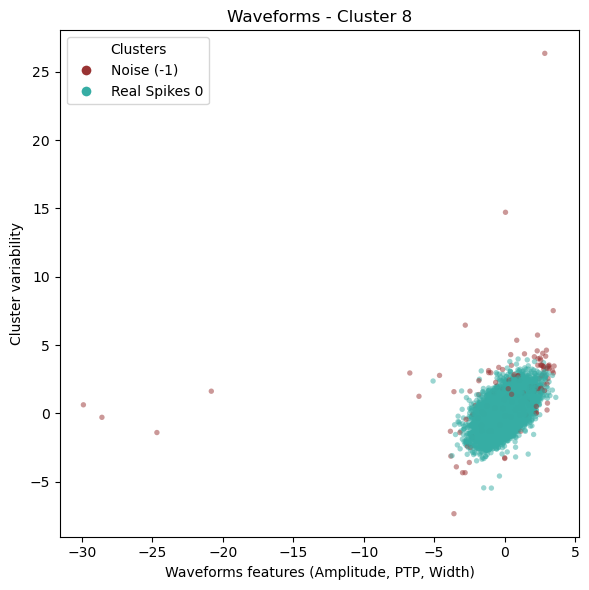

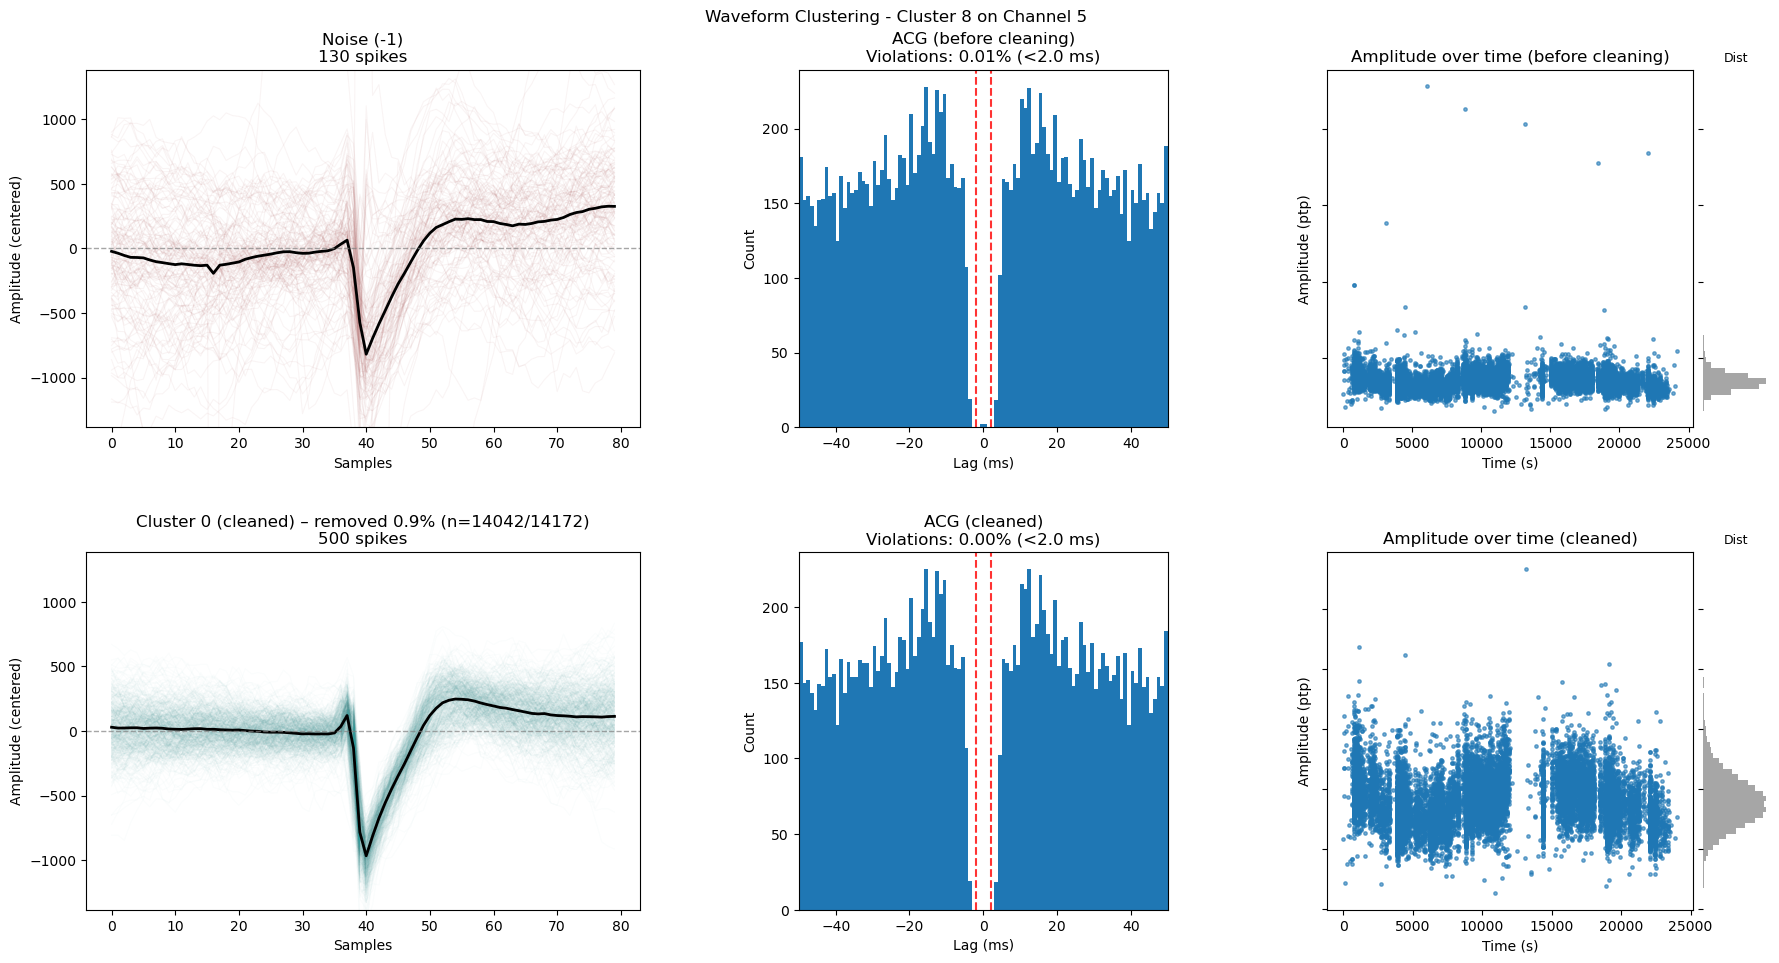

[SAVE] Clean: 14042   Noise: 130   (total 14172)
[INFO] Processing cluster 12 on channel 5


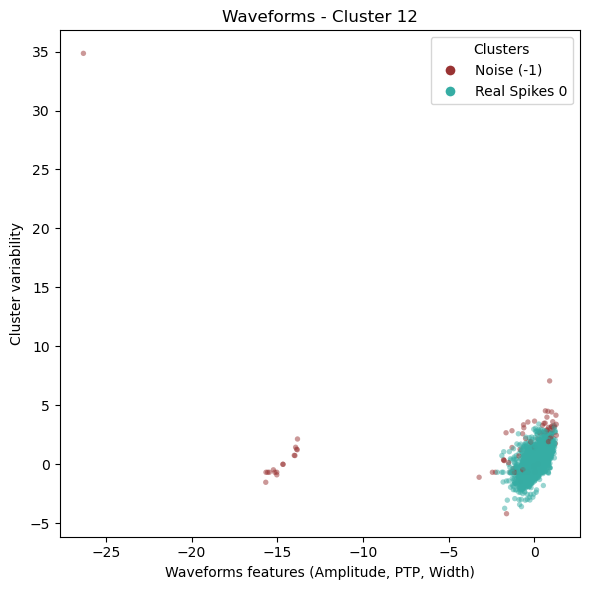

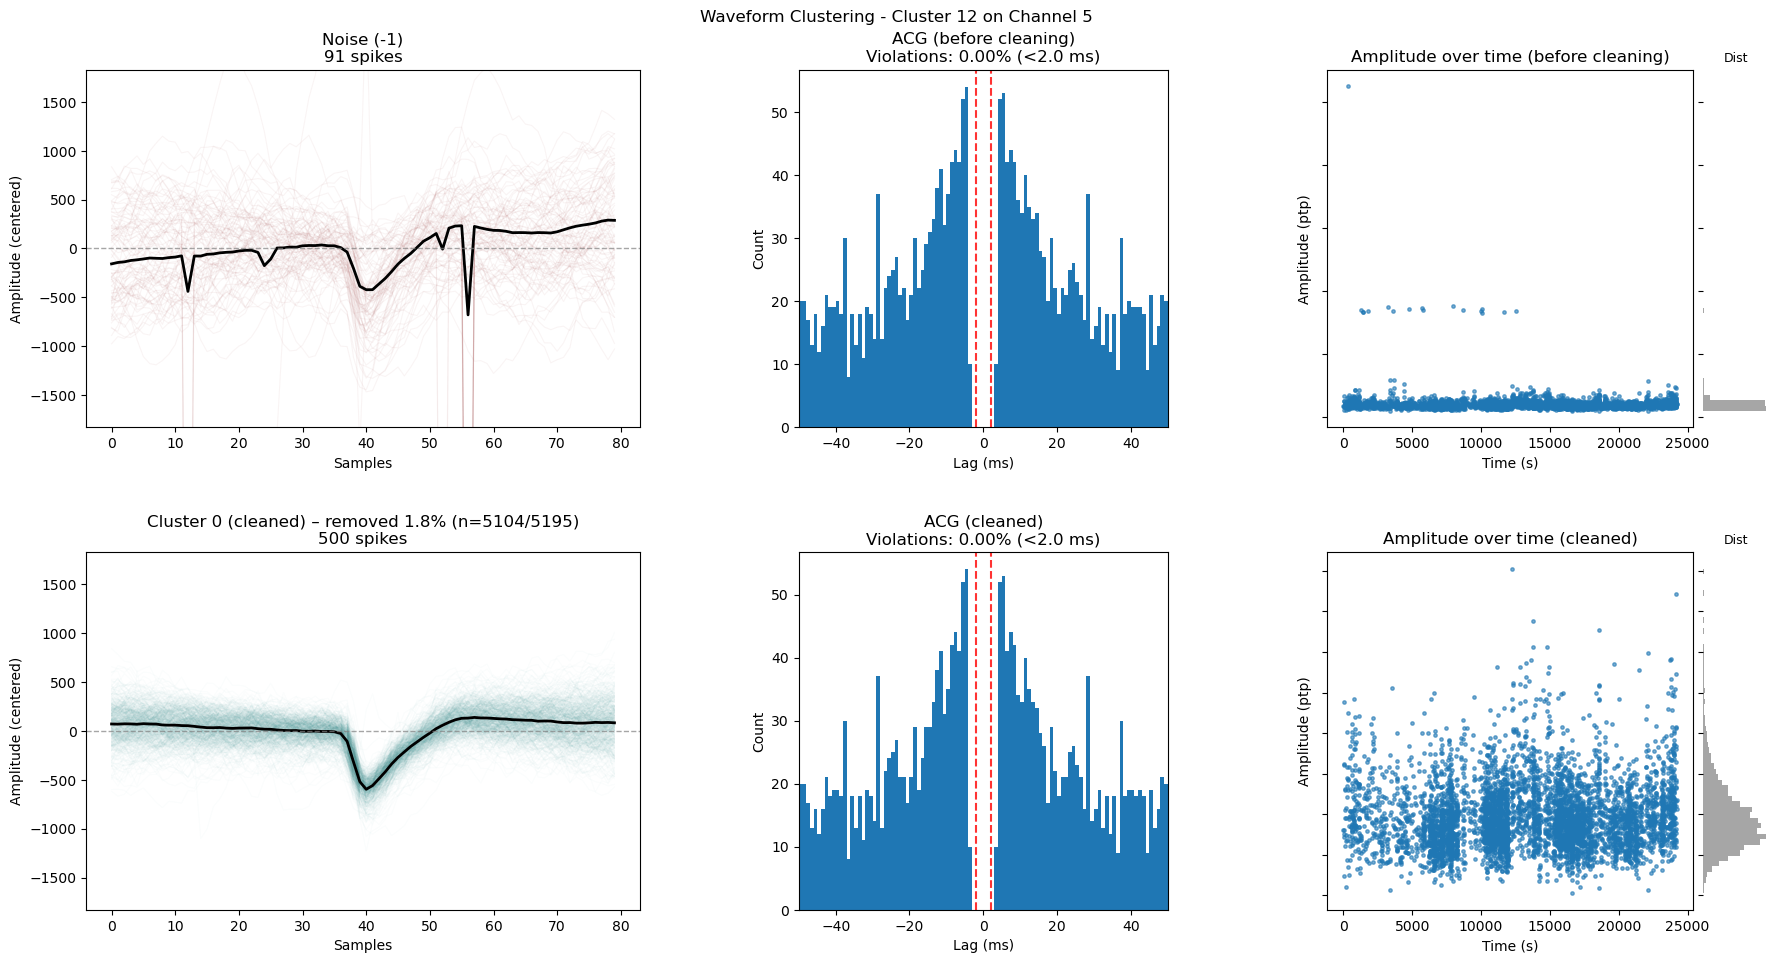

[SAVE] Clean: 5104   Noise: 91   (total 5195)
[INFO] Processing cluster 41 on channel 10


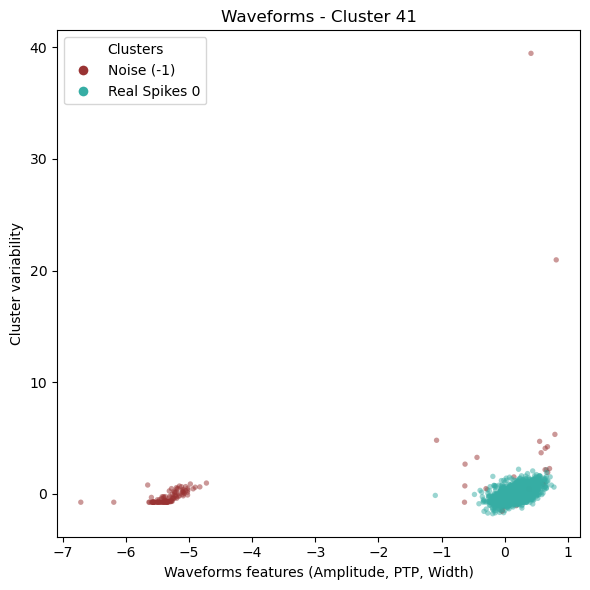

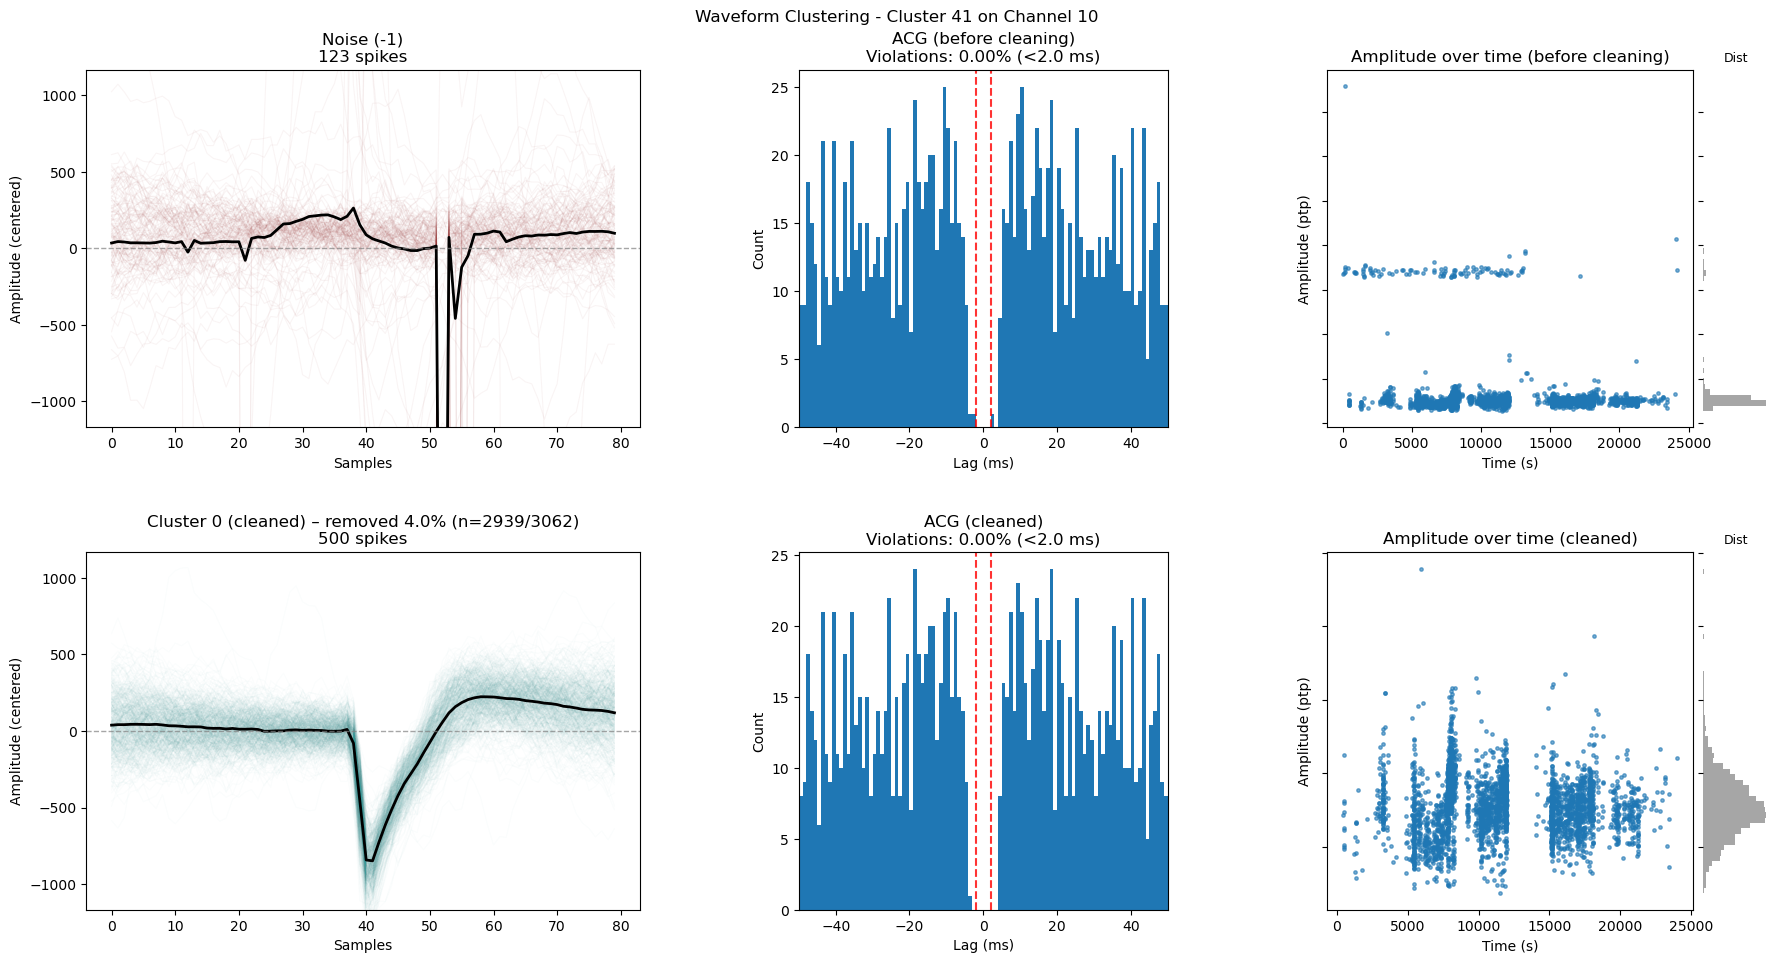

[SAVE] Clean: 2939   Noise: 123   (total 3062)
[INFO] Processing cluster 90 on channel 26


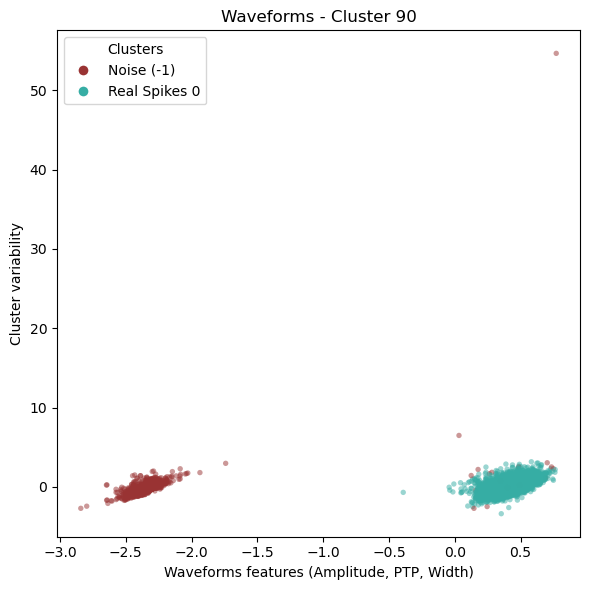

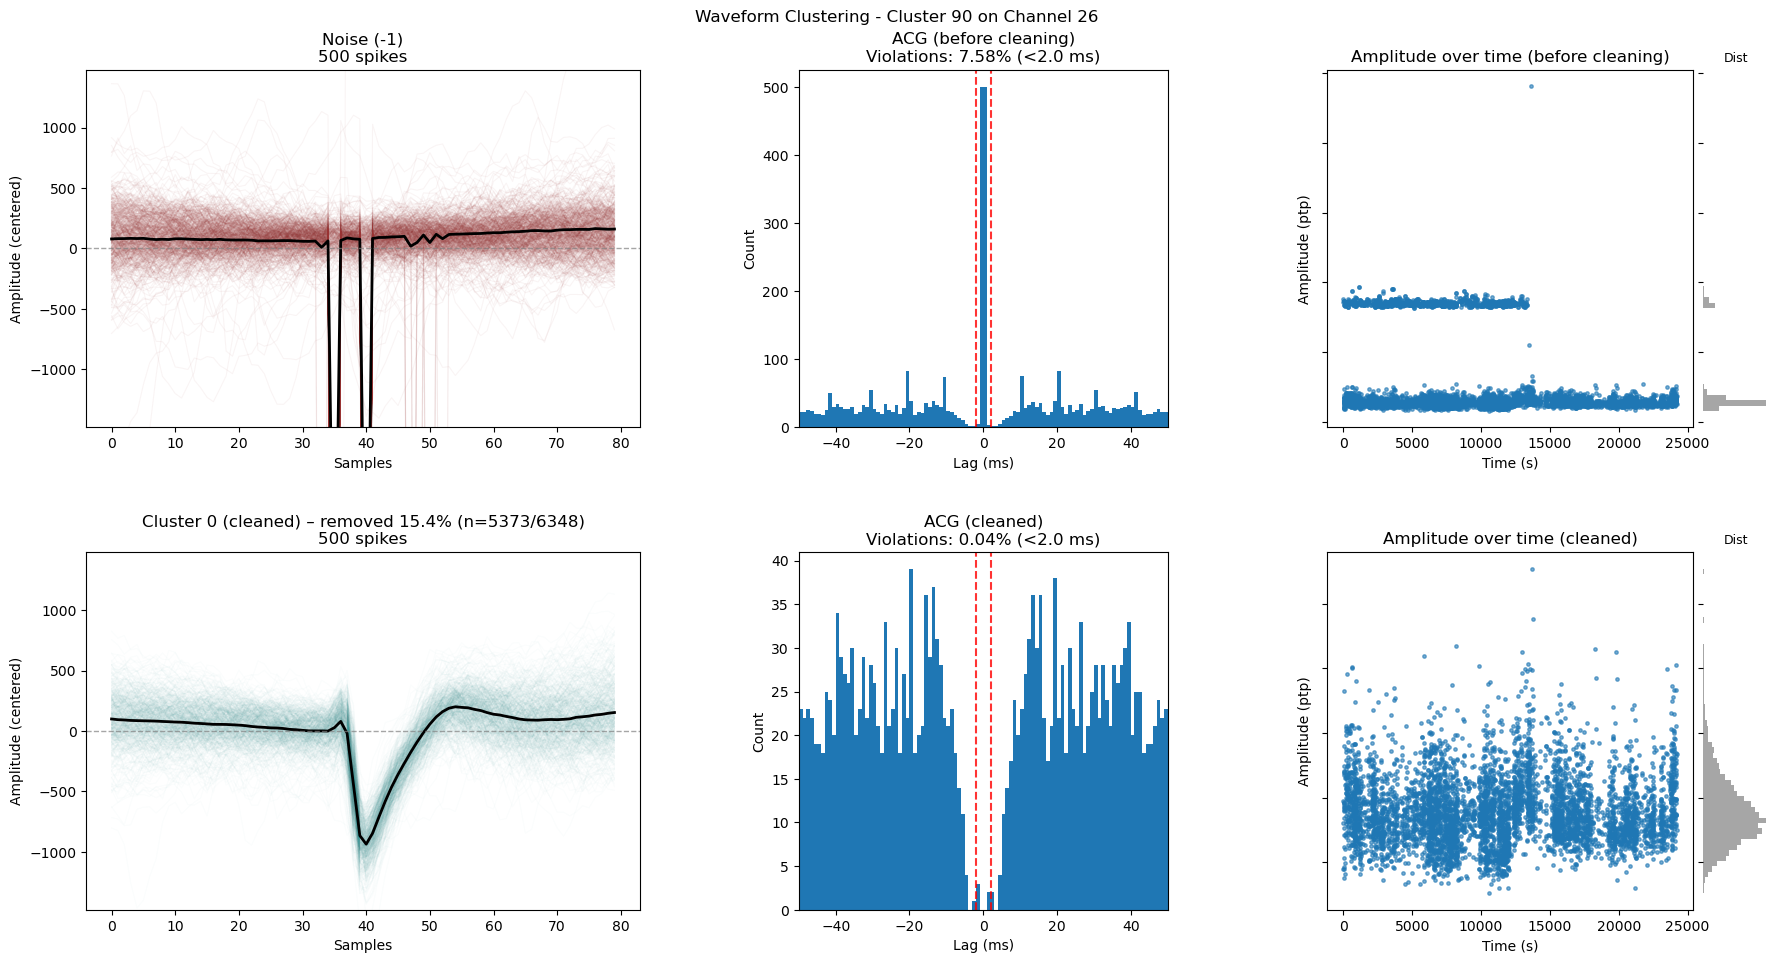

[SAVE] Clean: 5373   Noise: 975   (total 6348)
[INFO] Processing cluster 103 on channel 31


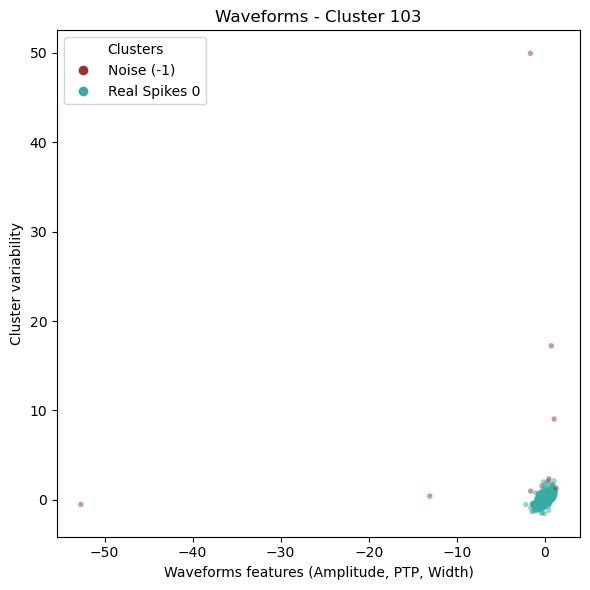

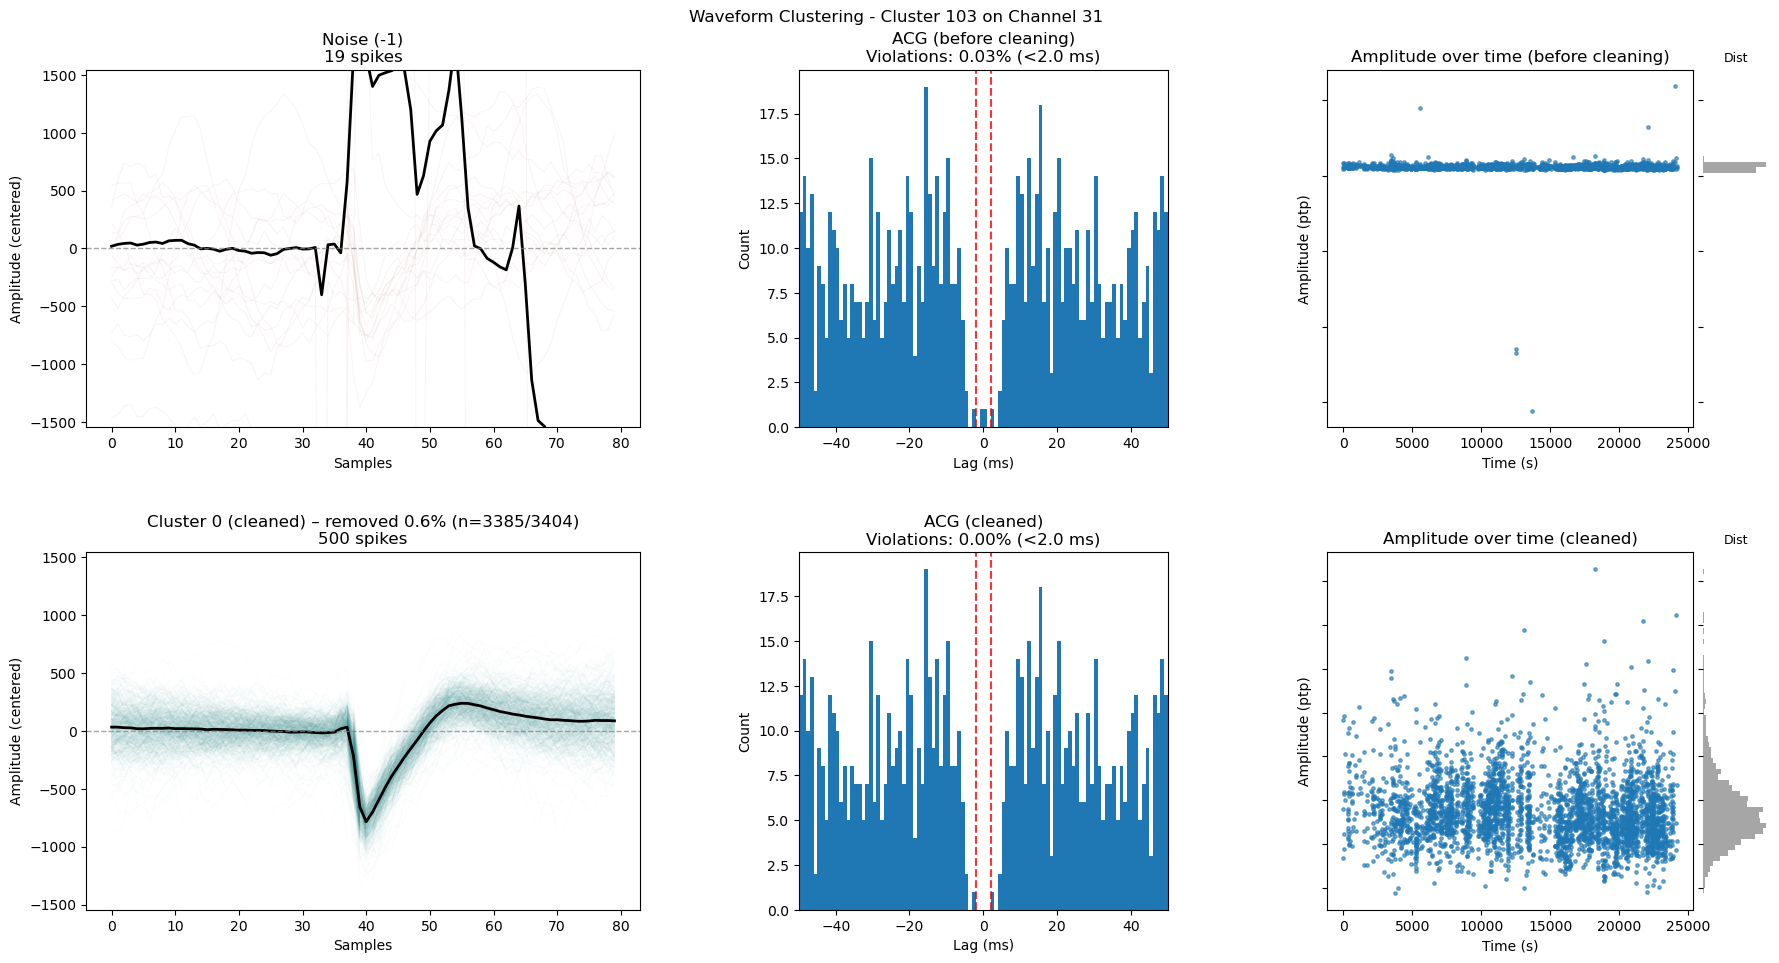

[SAVE] Clean: 3385   Noise: 19   (total 3404)
[INFO] Processing cluster 151 on channel 44


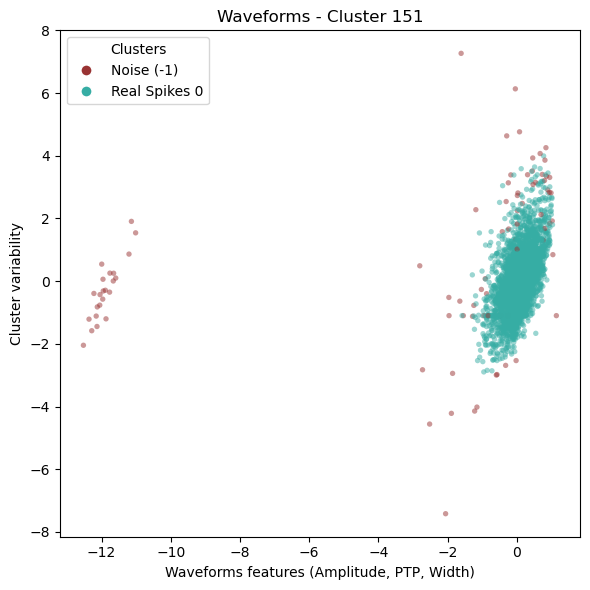

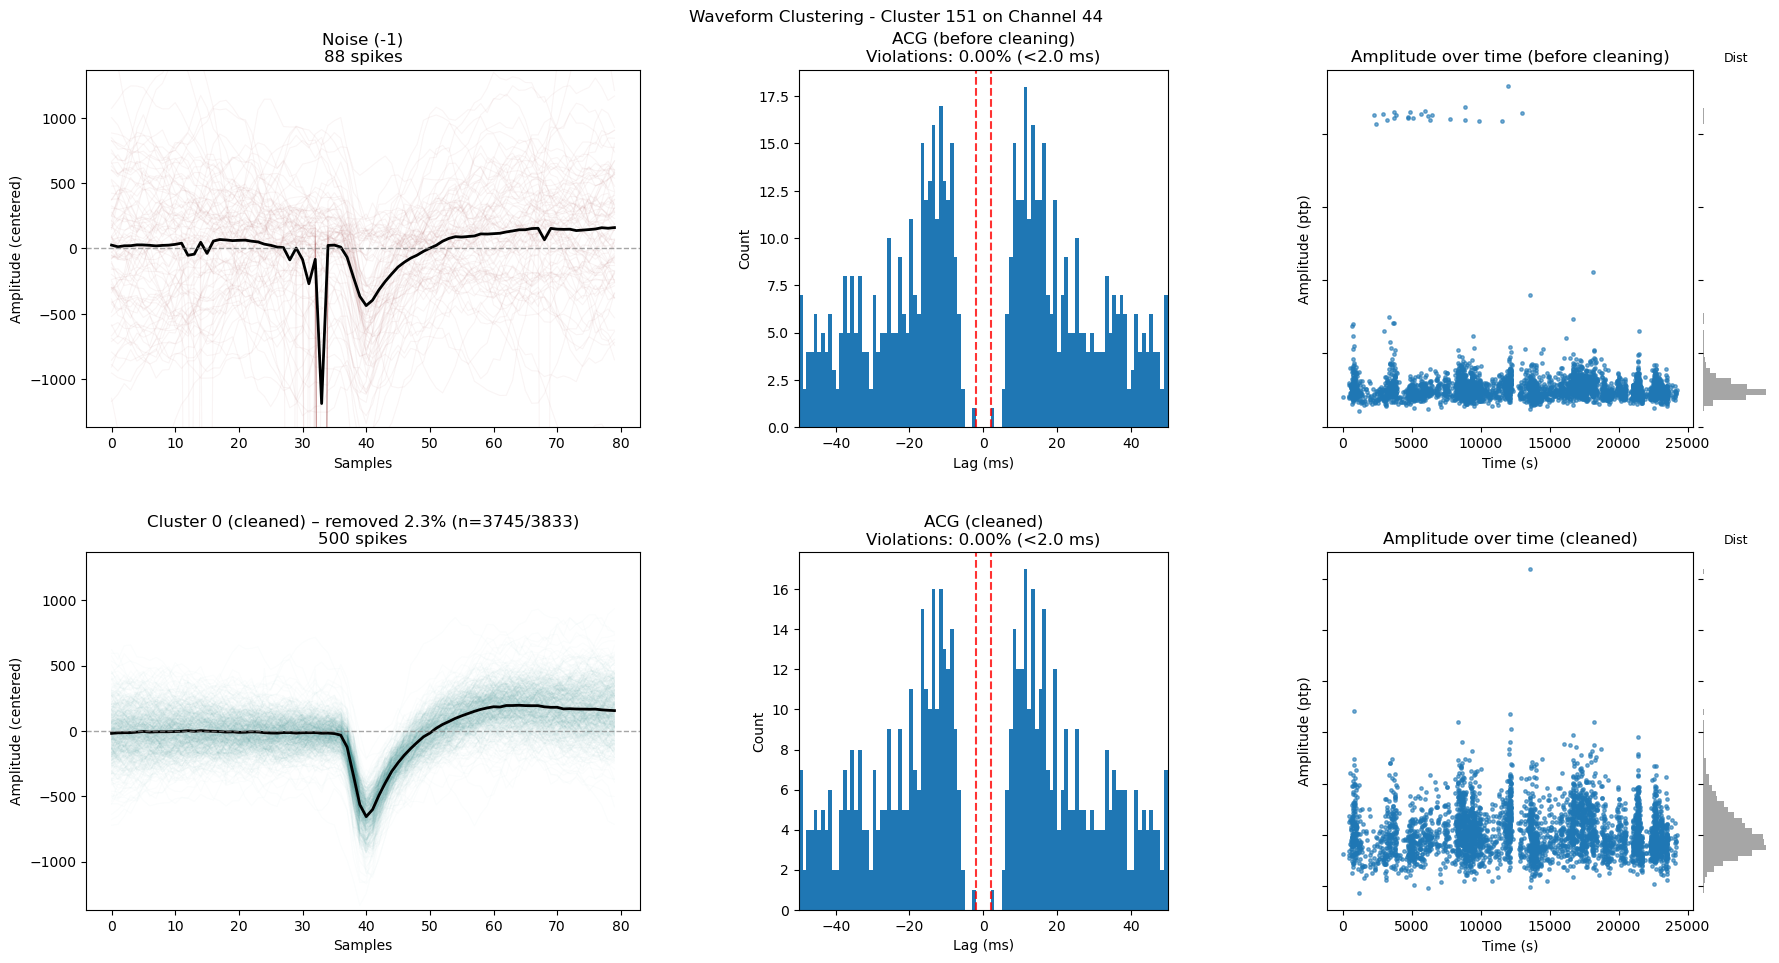

[SAVE] Clean: 3745   Noise: 88   (total 3833)
[INFO] Processing cluster 183 on channel 43


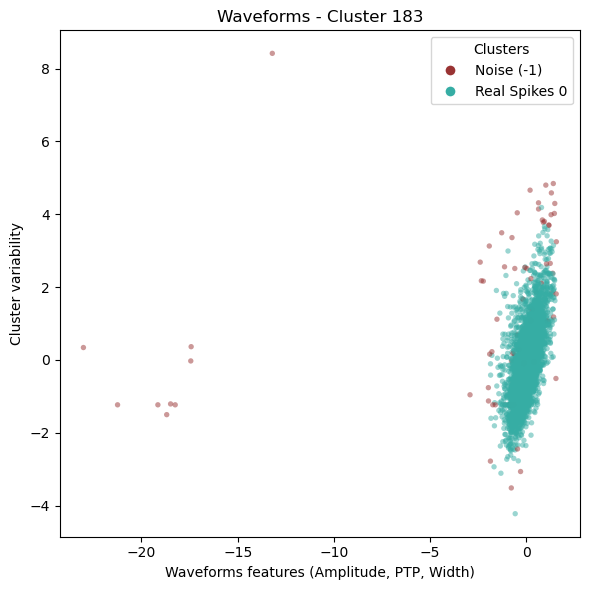

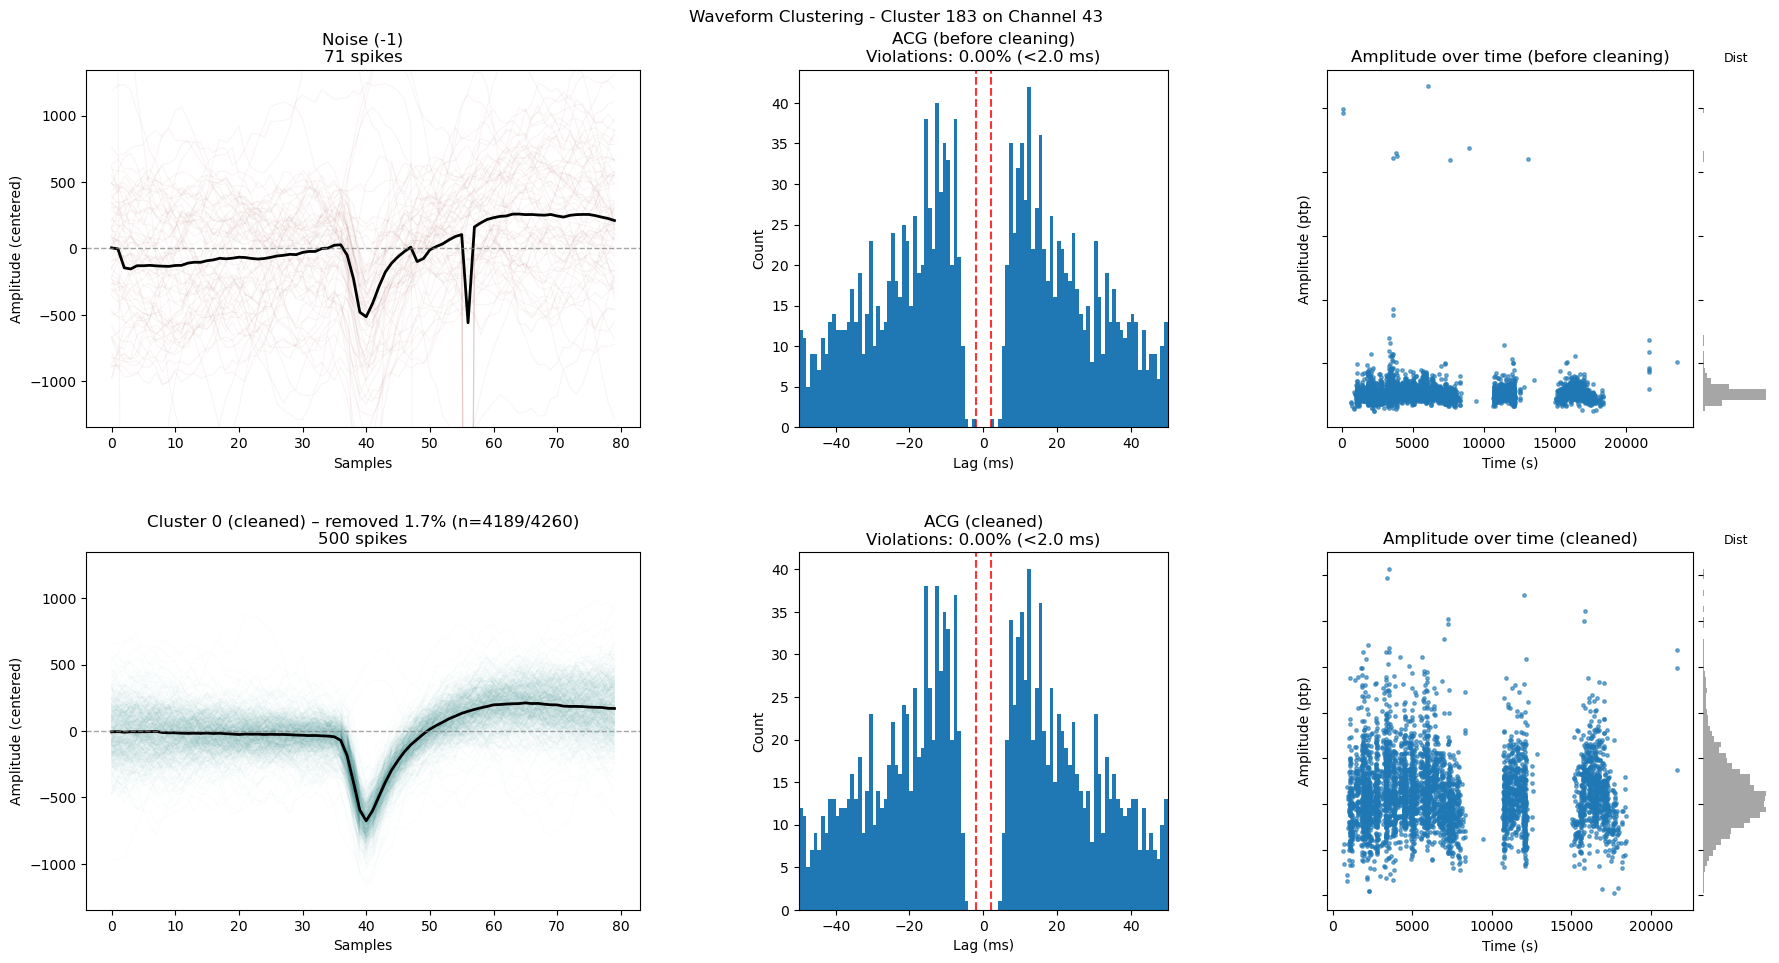

[SAVE] Clean: 4189   Noise: 71   (total 4260)
[INFO] Processing cluster 467 on channel 138


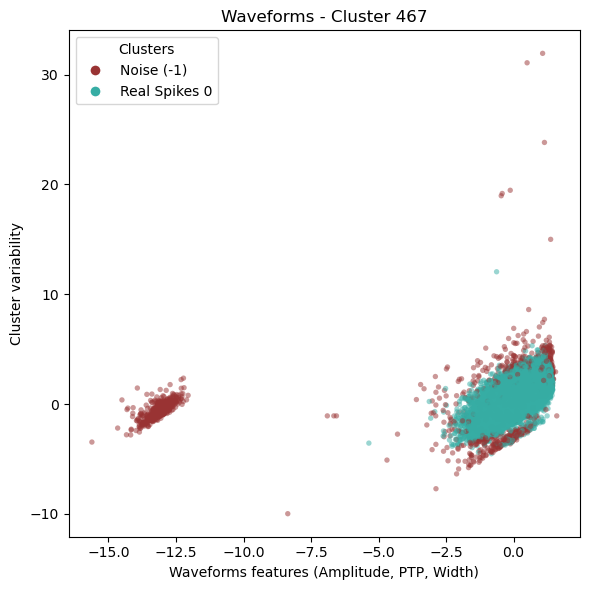

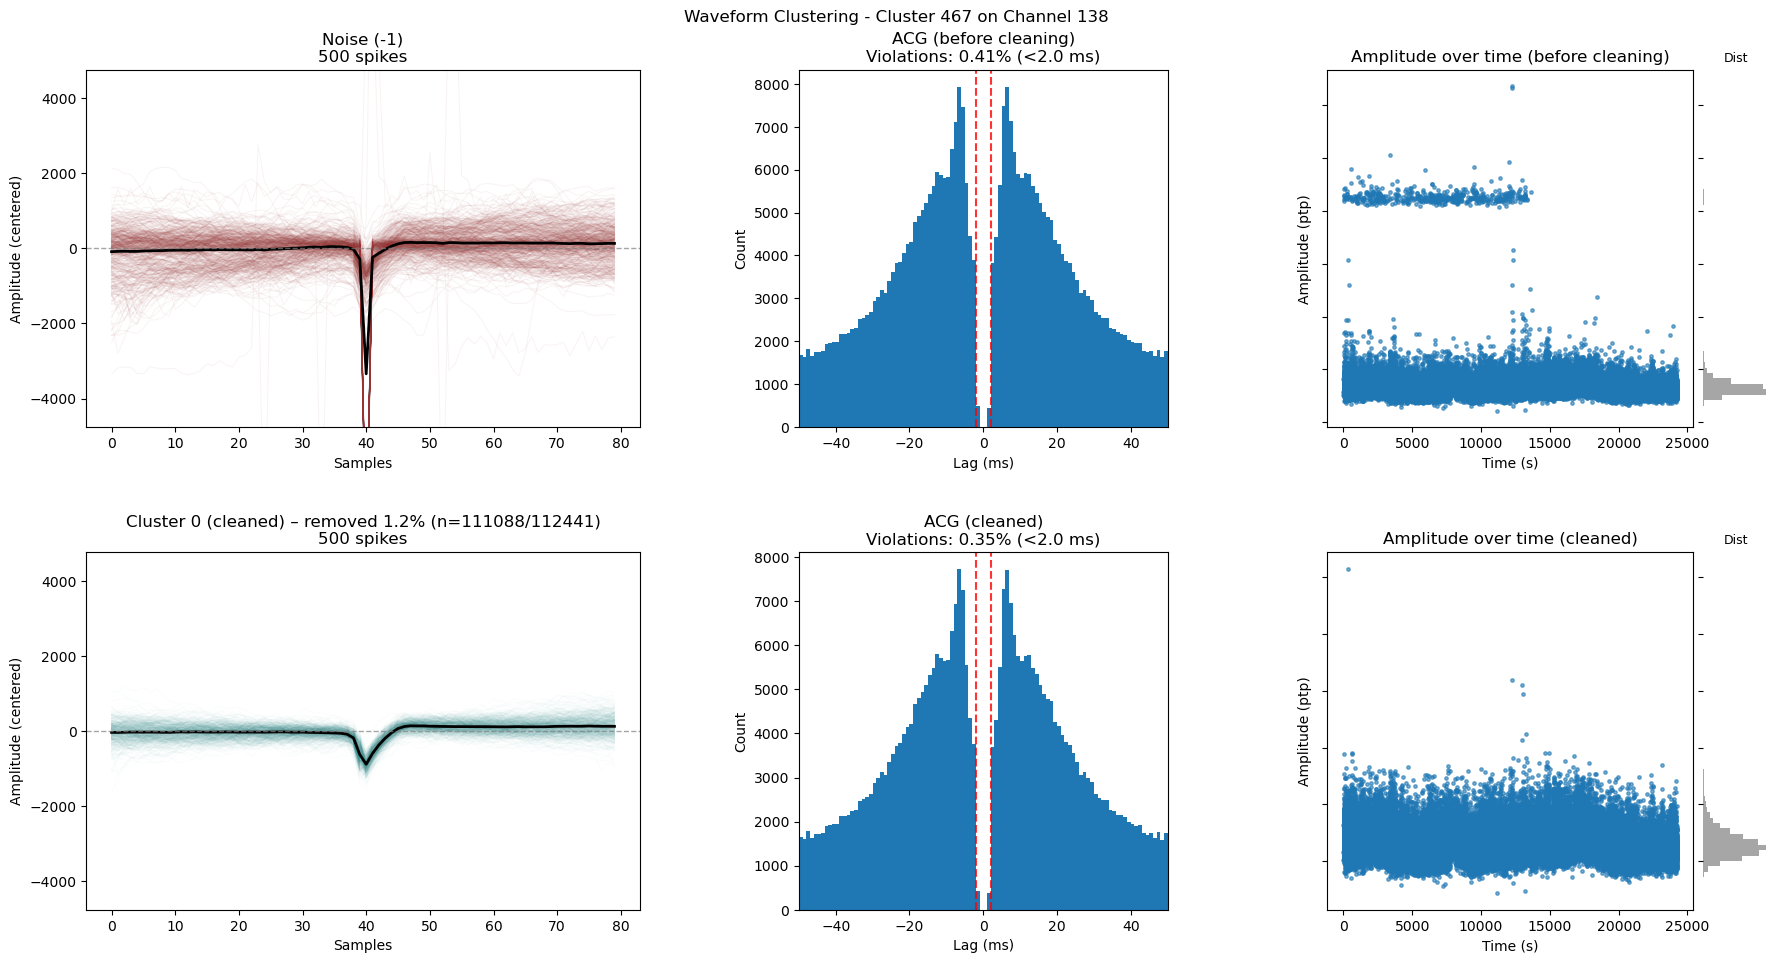

[SAVE] Clean: 111088   Noise: 1353   (total 112441)
[INFO] Processing cluster 674 on channel 133


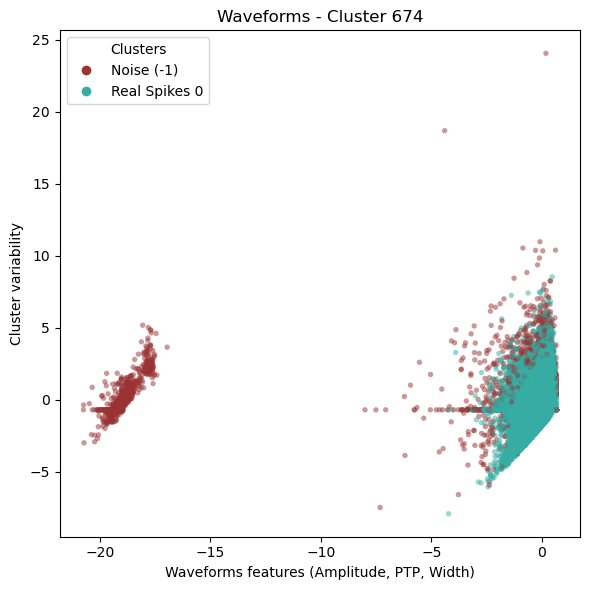

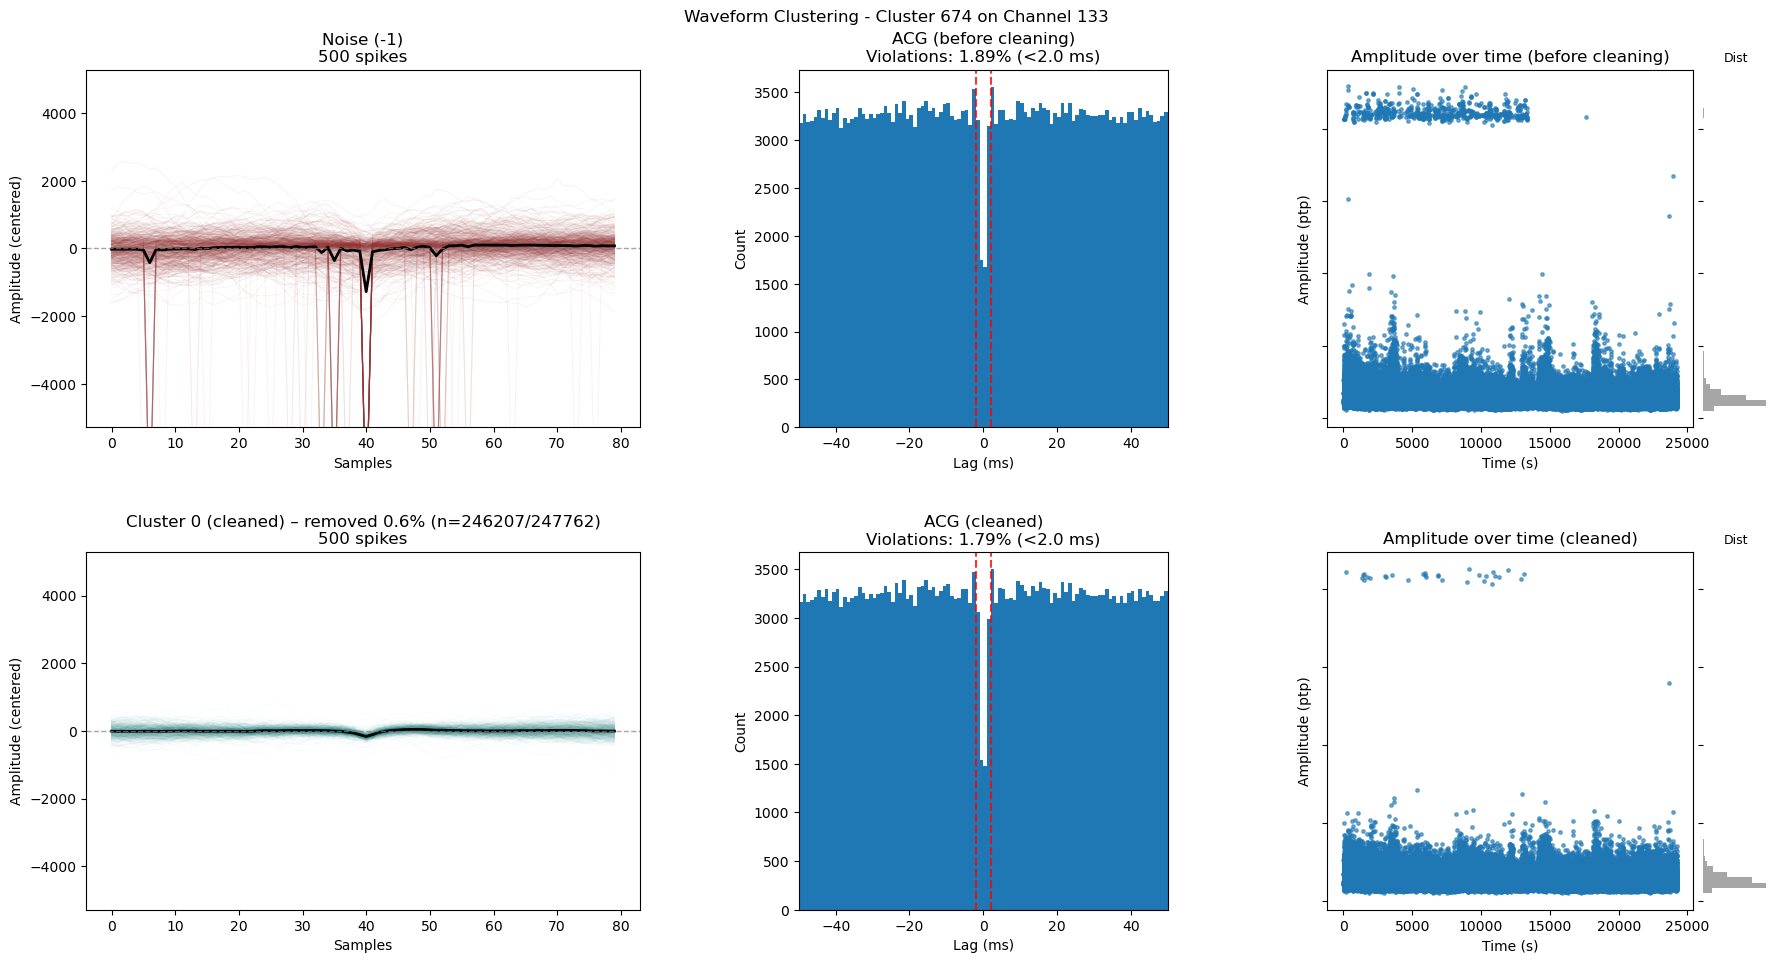

[SAVE] Clean: 246207   Noise: 1555   (total 247762)
[INFO] Processing cluster 725 on channel 128


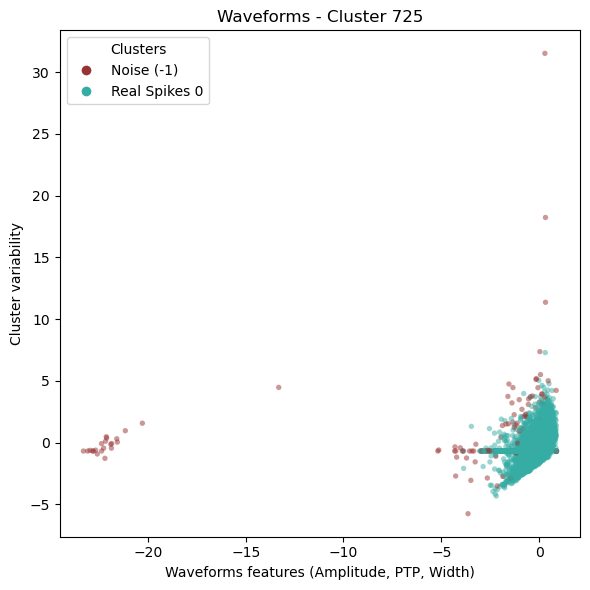

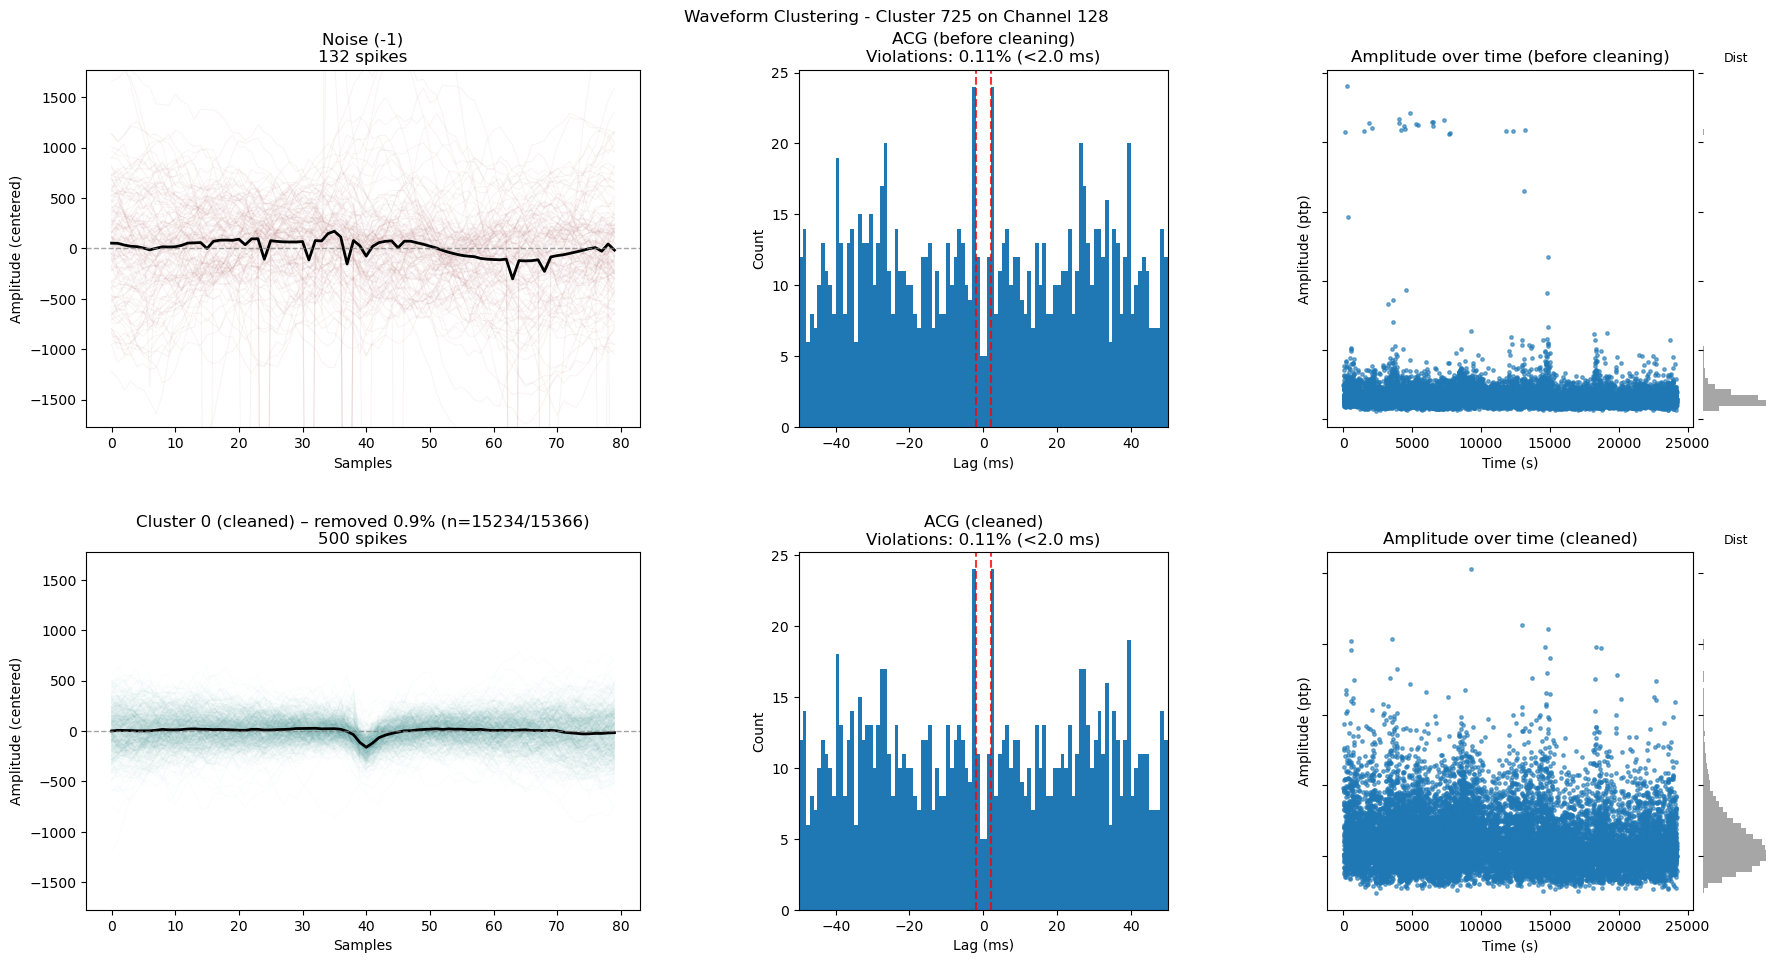

[SAVE] Clean: 15234   Noise: 132   (total 15366)
[INFO] Processing cluster 811 on channel 95


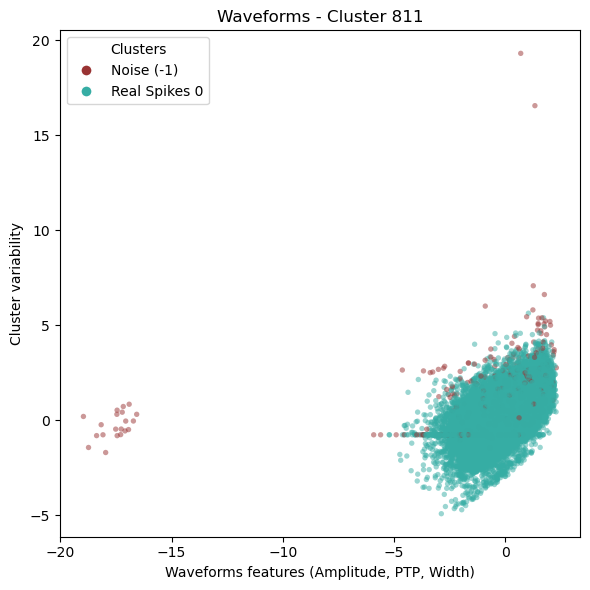

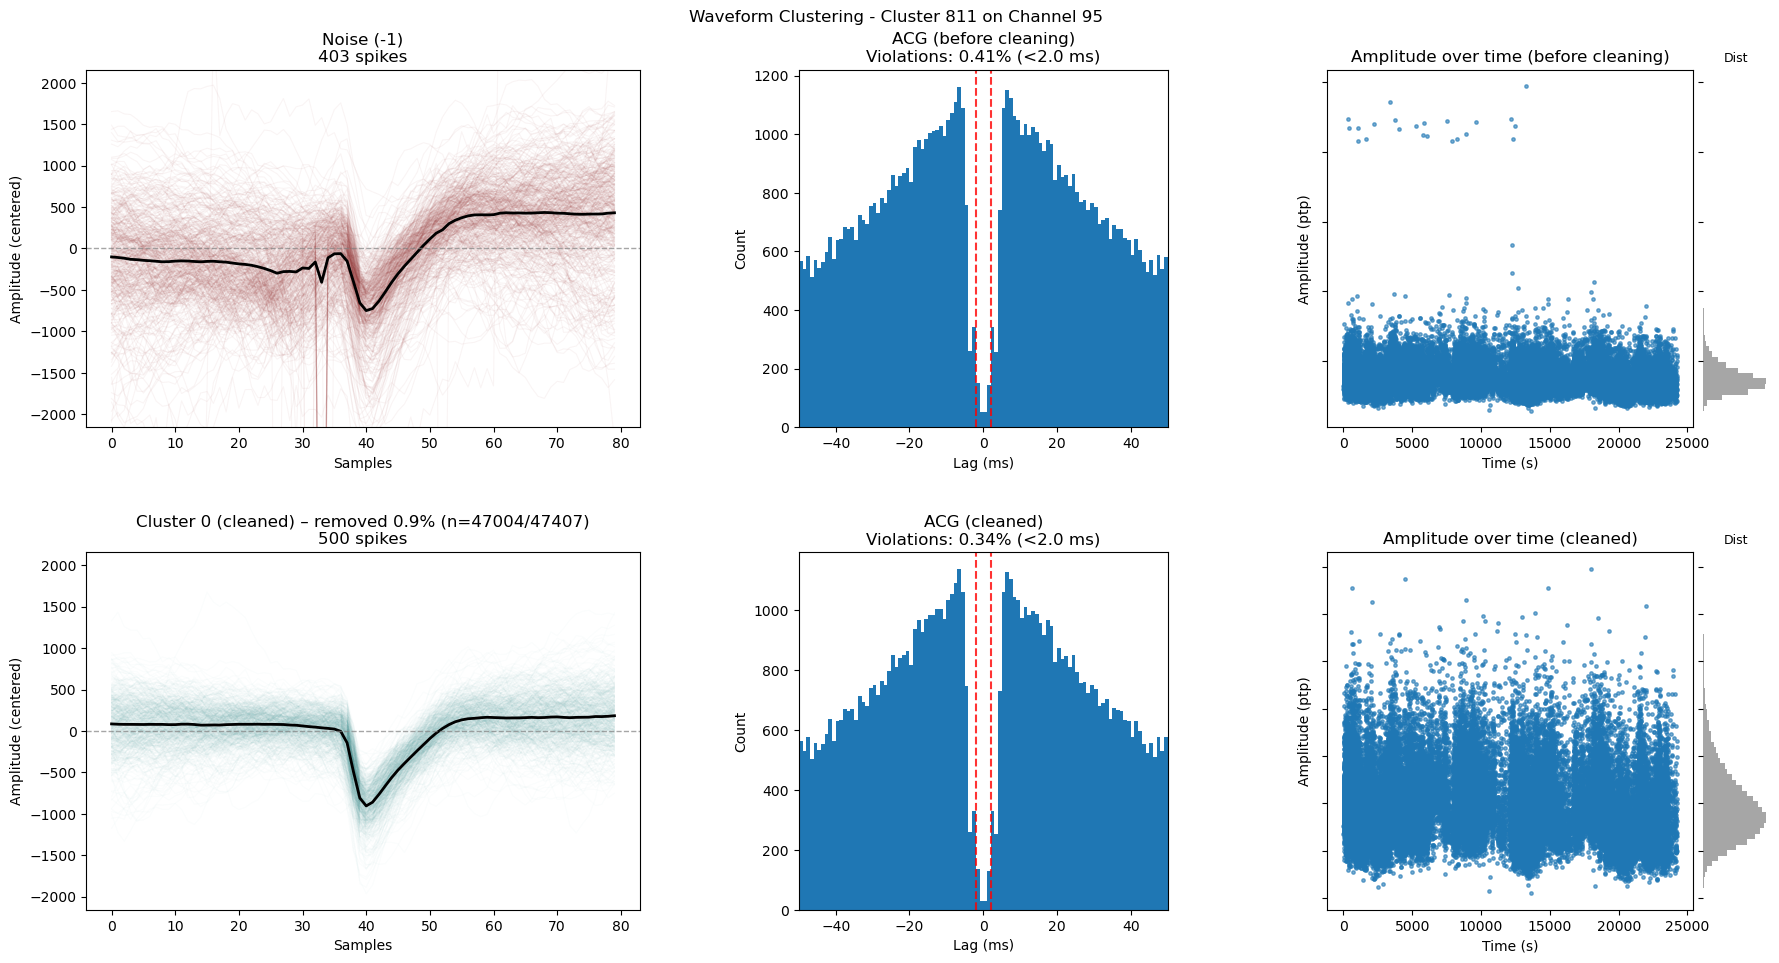

[SAVE] Clean: 47004   Noise: 403   (total 47407)
[INFO] Processing cluster 858 on channel 87


In [ ]:
# ─── Config of the sessions to run the cleaning, here is necessary to precise all the paths for it to run properly  ─────────────────────────────────────────────────────────────────────────────────────────────────────
session_name = "RAT188-06032024"
data_folder  = fr'E:\CHEESEBOARDMAZE\Rat188\Task\{session_name}\Spykeline\SpikeSorting\sorter_output'
raw_dat_path = fr'E:\CHEESEBOARDMAZE\Rat188\Task\{session_name}\{session_name}.dat'
mapping_csv_path = fr'E:\CHEESEBOARDMAZE\Rat188\Task\{session_name}\{session_name}_CP.csv'
output_folder = fr'E:\CHEESEBOARDMAZE\Rat188\Task\{session_name}'
os.makedirs(output_folder, exist_ok=True)

n_channels = 169      # Number of channels recorded in the session, including the accelerometers
dtype = np.int16     
sample_rate = 20000.0 # Sampling frequency of the recordings
snippet_ms = 4.0      # Time window around the spike to get the waveforms 

max_dbscan_samples = 5000   # Downsample limit , since someclusters can be too large and DBSCAN can not handle them is recommended to use a sample of the data to train the dbscan. 


# ─── Loop trhough all the clusters of the choosen session  ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    ks_data = load_ks_data(data_folder)
    cluster_channel_map = load_cluster_channel_mapping_from_csv(mapping_csv_path)

    missing_in_good = sorted(set(cluster_channel_map.keys()) - set(ks_data['good_clusters']))
    if missing_in_good:
        print(f"[INFO] {len(missing_in_good)} clusters in CSV are not labeled 'good' in Kilosort; they will be ignored.")

    for cluster_id in ks_data['good_clusters']:
        classify_and_save_cluster(
            cluster_id, ks_data, cluster_channel_map,
            eps=4.2,          # Increase if the cluster is passing noise
            min_samples=2,    # Minimal number of waveforms to compose each DBSCAN groups
            max_dbscan_samples=max_dbscan_samples,
            rescue=True, rescue_ptp_q=0.30, rescue_snr_q=0.30, rescue_mahal=1.5  # aditional step to remove any noise that would have passed by the cleaning 
        )

    print("\n✅ All clusters processed.")
